In [2]:
import os
import sys
from chordUtils import json2lab, MBIDAwareKFold
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='spherical',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [3]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [4]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(mbids, kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = MBIDAwareKFold(n_splits = nfolds, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(mbids):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(mbids, kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(mbids, kinds, chromas, ncomp, nfolds=5, debug=debug)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

In [5]:
symcomponents = np.array([1,15,20,40])
chromaFile = '../chroma130.npz'

# No normalization

maj 71.8331503842 %
min 62.9650194336 %
dom 51.109940288 %
hdim7 58.4651898734 %
dim 72.0973782772 %
total:  60.2786223316 %
maj BIC:  260728.981946  N:  18
min BIC:  202369.318955  N:  16
dom BIC:  467116.52515  N:  20
hdim7 BIC:  24467.3440863  N:  4
dim BIC:  29878.5986626  N:  6


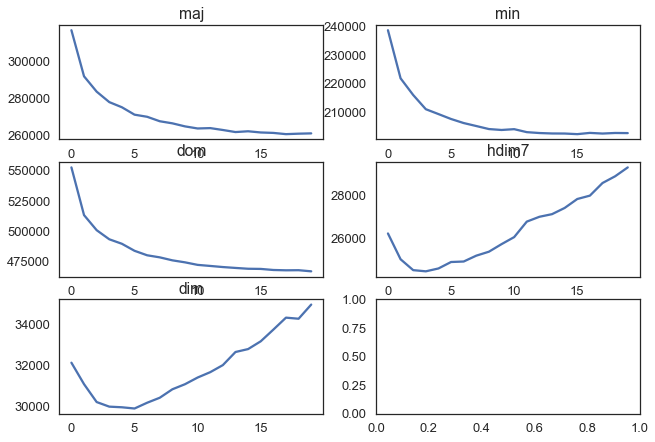

[ 18.  16.  20.   4.   6.]


In [6]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

#violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas, max_components=20)
print n_components


Time span:  46.315418005
[ 60.35932356  62.8762312   63.26337354  64.50358383]
[ 60.19800418  61.00979405  61.07369444  61.17264037]


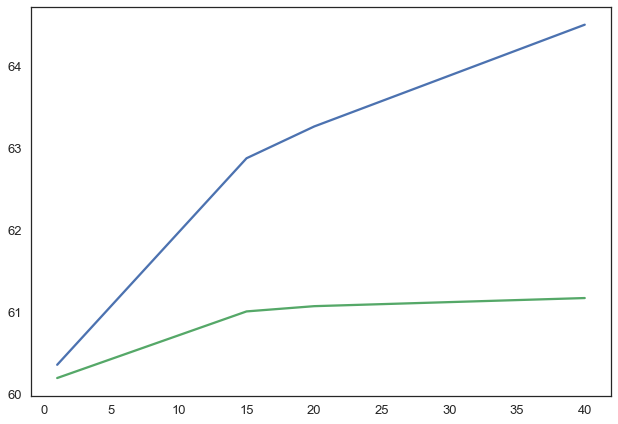

In [7]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

start = time.time()
rawTrains, rawTests = trainTestSymmetricalModels(mbids, kinds, chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print rawTrains
print rawTests
plt.plot(symcomponents, rawTrains)
plt.plot(symcomponents, rawTests)
plt.show()

maj 70.4994511526 %
min 65.8126437693 %
dom 59.5433789954 %
hdim7 57.832278481 %
dim 68.6017478152 %
total:  64.2246995801 %
maj BIC:  471363.213994  N:  10
min BIC:  341798.288336  N:  9
dom BIC:  758067.899983  N:  17
hdim7 BIC:  36815.740366  N:  3
dim BIC:  44229.3787316  N:  3


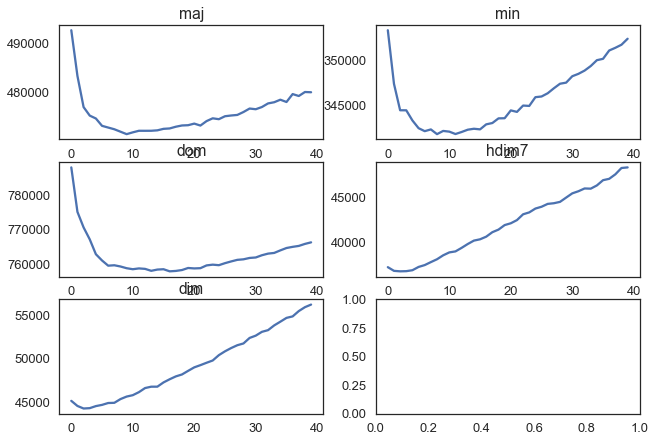

[ 10.   9.  17.   3.   3.]


In [8]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
#violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
score(model, kinds, sxChromas, debug=True)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components



# Log-ratio transform

Time span:  63.0497088432
[ 64.25379944  65.09354089  65.38707866  66.63089616]
[ 63.86543253  62.82558665  62.66912537  62.69126664]


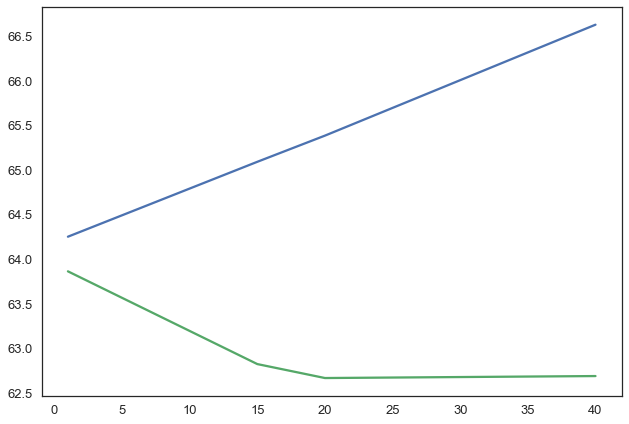

In [9]:
# Compositional data model
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
start = time.time()
sxTrains, sxTests = trainTestSymmetricalModels(mbids, kinds, sxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print sxTrains
print sxTests
plt.plot(symcomponents, sxTrains)
plt.plot(symcomponents, sxTests)
plt.show()




# Just L1

maj 72.2502744237 %
min 62.9332910288 %
dom 50.5971197752 %
hdim7 57.832278481 %
dim 72.4094881398 %
total:  60.1547544359 %
Time span:  42.5291228294
[ 60.24555257  62.87973252  63.25055739  64.36293337]
[ 60.11394534  60.82084199  61.11402295  60.99698712]


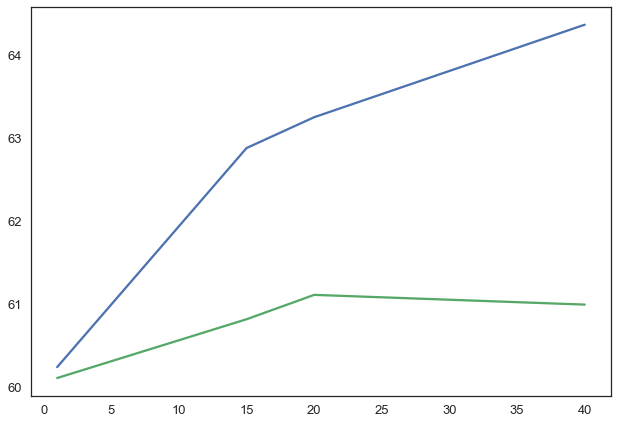

In [10]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1Chromas = normalize(chromas)
#violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1Chromas)
#print n_components
start = time.time()
l1Trains, l1Tests = trainTestSymmetricalModels(mbids, kinds, l1Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1Trains
print l1Tests
plt.plot(symcomponents, l1Trains)
plt.plot(symcomponents, l1Tests)
plt.show()



# L1-log

maj 68.979143798 %
min 64.8687237249 %
dom 60.5690200211 %
hdim7 55.4588607595 %
dim 69.1011235955 %
total:  64.0220066599 %
Time span:  57.817707777
[ 64.09763578  64.89543595  65.10265527  66.12872465]
[ 63.62195623  62.53285146  62.24407598  61.75918603]


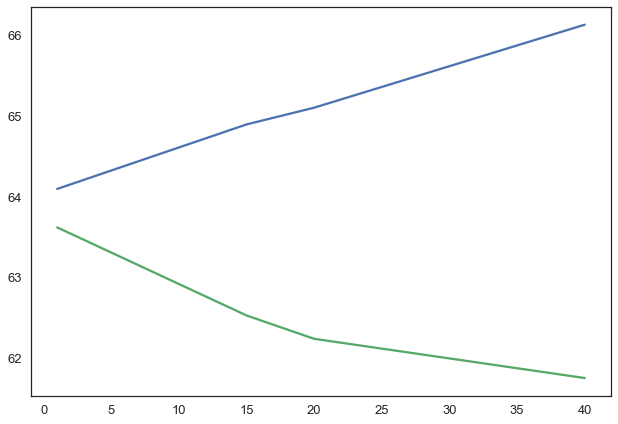

In [11]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1logChromas = logNormalize(chromas)
#violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1logChromas)
#print n_components
start = time.time()
l1logTrains, l1logTests = trainTestSymmetricalModels(mbids, kinds, l1logChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1logTrains
print l1logTests
plt.plot(symcomponents, l1logTrains)
plt.plot(symcomponents, l1logTests)
plt.show()


# L2

maj 73.7266739846 %
min 63.5916554295 %
dom 48.8830347734 %
hdim7 58.8607594937 %
dim 71.6604244694 %
total:  59.93758345 %
Time span:  45.2226238251
[ 60.00202322  62.7848025   63.34308876  64.39790199]
[ 59.86595742  61.40031018  61.42277097  60.97713563]


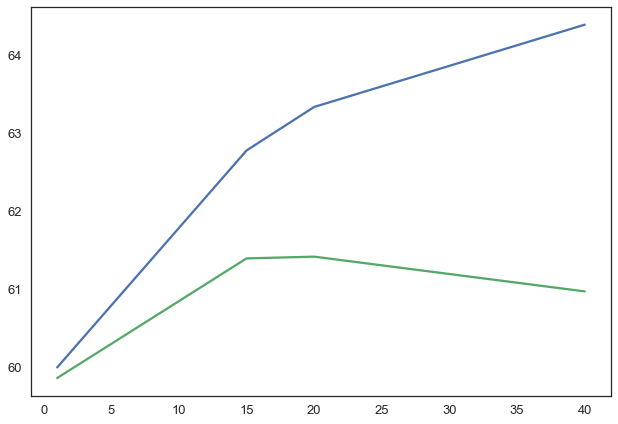

In [12]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l2Chromas = normalize(chromas, norm='l2')
#violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas, debug=True)
#model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
#score(model, kinds, l2Chromas)
#n_components = findOptimalNComponentsByBIC(l2Chromas)
#print n_components
start = time.time()
l2Trains, l2Tests = trainTestSymmetricalModels(mbids, kinds, l2Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l2Trains
print l2Tests
plt.plot(symcomponents, l2Trains)
plt.plot(symcomponents, l2Tests)
plt.show()



# Lmax

maj 74.220636663 %
min 63.3536923931 %
dom 48.0154548648 %
hdim7 59.2563291139 %
dim 70.4744069913 %
total:  59.614239982 %
Time span:  55.5238940716
[ 59.72801425  62.46401407  62.76774957  63.99472917]
[ 59.60216442  60.83918679  60.84733352  60.83842556]


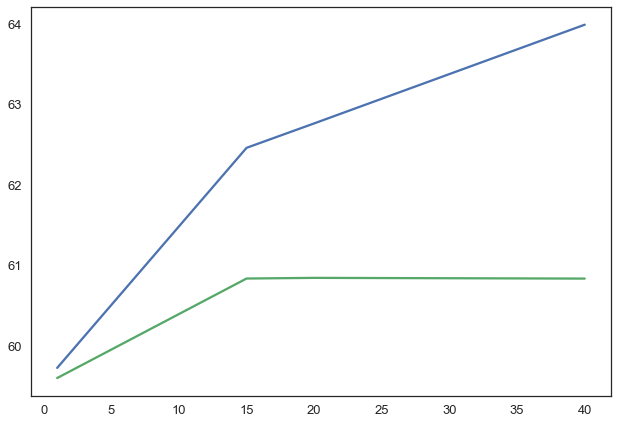

In [13]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

maxChromas = normalize(chromas, norm='max')
#violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas, debug=True)
#model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
#score(model, kinds, maxChromas)
#n_components = findOptimalNComponentsByBIC(maxChromas)
#print n_components
start = time.time()
maxTrains, maxTests = trainTestSymmetricalModels(mbids, kinds, maxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print maxTrains
print maxTests
plt.plot(symcomponents, maxTrains)
plt.plot(symcomponents, maxTests)
plt.show()

<h1> Recap from previous series.</h1>
I'm working on chord estimation for jazz audio recordings.
Primary task: identify root and chord type:
<ul>
<li> maj
<li> min
<li> dom
<li> hdim7
<li> dim
</ul>

<h2>Idea is to: </h2>
<ul>
<li> detect beats (may be: down beats,  periods by 4, 8 bars, e.g. deeper hierarchy)
<li> for each beat estimate probability of each possible chord
<li> plugin these probabilities into some model to count adjacent chord dependencies
     (and ideally: relation to segments of higher order).
</ul>     

<h2>Done before:</h2>
<ul>
<li> Have 3 datasets ("The Beatles", "Jazz": 62163 beats annotated, "Guitar": 289 beats annotated)
<li> Beat tracking: madmom
<li> NNLS Chroma: appears to be best available as shown with experiment on "The Beatles" dataset.
     Was evaluated only practically.
     Chroma = 12D vector (per value for each semintone pitch class).
<li> Preliminary chroma distribution exploration. Conclusion: after per-sample normalization, it becomes
     very "un Gaussian" (e.g. distributed  in lower dimensional spaece with boundaries, very skewed).
     For L1: it's distributed on simplex. Then, try:
     <ul>
     <li> L1 + logarithm
     <li> L1 + transform to 11D
     </ul>
</ul>

<h2> This week: </h2>
 Fit GMM model to "jazz" and "guitar" dataset. How it's evaluated:
 <ul>
 <li> All chords converted to C (only chord kind is predicted)
 <li> 5-Fold crossvalidation is used
 <li> Naive bayes classifier is applied to trained GMM to detedct chord kind.
 </ul>
 
 <h2> Results: </h2>
 <li> GMM with 60 components gives 75% test accuracy.
      (it's possible to gain almost 100% training accuracy).
      For guitar: 90% test accuracy with simple Gaussian (no mixture).
 <li> NNLS chroma features are not behaved as expected. It seems
      to compress loudness somehow, so normalization isn't necessary.
      It doens't respect perceptual model (masking) and provides counterintuitive
      results. Chroma seems to be a black box now and it's a weak point.
      It seems it could be improved.
 <li> L1 and "Un-simplex": shows better results for low number of components.
      L1 reflects perceptual/musicological approach: (proportions, as in Pitch class profiles). 
      In general, why "unsimplex" is interesting?
      <ul>
      <li> best results for small number of components in GMM
 </ul>

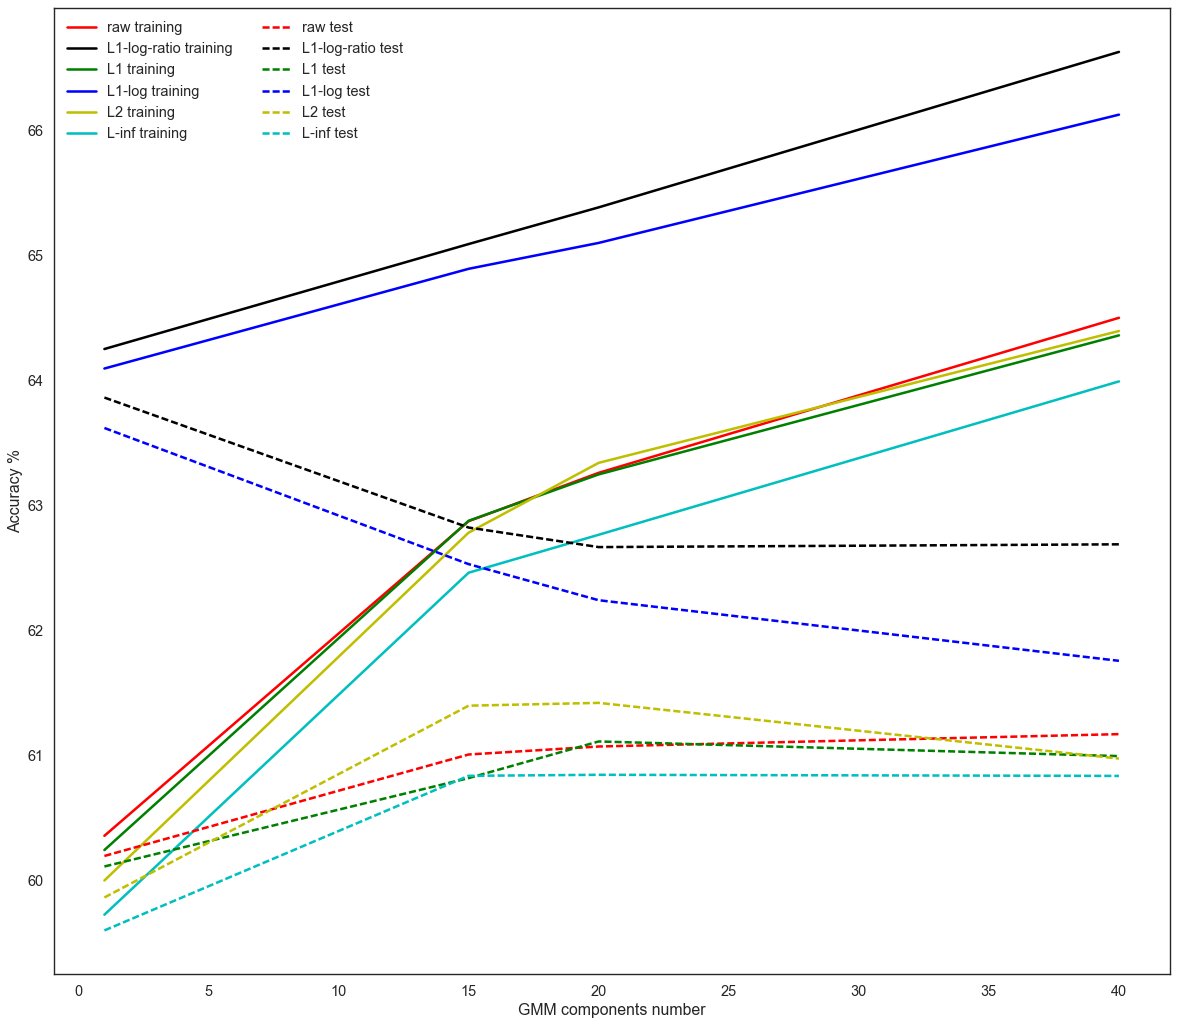

Norm / N of components,1,15,20,40
Raw,60.36,62.88,63.26,64.5
L1-log-ratio,64.25,65.09,65.39,66.63
L1,60.25,62.88,63.25,64.36
L1-log,64.1,64.9,65.1,66.13
L2,60.0,62.78,63.34,64.4
L-inf,59.73,62.46,62.77,63.99


Norm / N of components,1,15,20,40
Raw,60.2,61.01,61.07,61.17
L1-log-ratio,63.87,62.83,62.67,62.69
L1 test,60.11,60.82,61.11,61.0
L1-log,63.62,62.53,62.24,61.76
L2 test,59.87,61.4,61.42,60.98
L-inf test,59.6,60.84,60.85,60.84


In [14]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
line, = plt.plot(symcomponents, rawTrains, 'r-')
line.set_label('raw training')
line, = plt.plot(symcomponents, sxTrains, 'k-')
line.set_label('L1-log-ratio training')
line, = plt.plot(symcomponents, l1Trains, 'g-')
line.set_label('L1 training')
line, = plt.plot(symcomponents, l1logTrains, 'b-')
line.set_label('L1-log training')
line, = plt.plot(symcomponents, l2Trains, 'y-')
line.set_label('L2 training')
line, = plt.plot(symcomponents, maxTrains, 'c-')
line.set_label('L-inf training')

line, = plt.plot(symcomponents, rawTests, 'r--')
line.set_label('raw test')
line, = plt.plot(symcomponents, sxTests, 'k--')
line.set_label('L1-log-ratio test')
line, = plt.plot(symcomponents, l1Tests, 'g--')
line.set_label('L1 test')
line, = plt.plot(symcomponents, l1logTests, 'b--')
line.set_label('L1-log test')
line, = plt.plot(symcomponents, l2Tests, 'y--')
line.set_label('L2 test')
line, = plt.plot(symcomponents, maxTests, 'c--')
line.set_label('L-inf test')

plt.xlabel('GMM components number')
plt.ylabel('Accuracy %')
plt.legend(ncol=2)
plt.show()
from IPython.display import HTML, display
def line2HTML(title, data):
    return '<tr><td>' + title + '</td><td>{}</td></tr>'.format(
        '</td><td>'.join(str(round(x,2)) for x in data))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTrains)
body = body + line2HTML('L1-log-ratio', sxTrains)
body = body + line2HTML('L1', l1Trains)
body = body + line2HTML('L1-log', l1logTrains)
body = body + line2HTML('L2', l2Trains)
body = body + line2HTML('L-inf', maxTrains)
display(HTML('<h3>Training Accuracy %</h3><table>' + header + body + '</table>'))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTests)
body = body + line2HTML('L1-log-ratio', sxTests)
body = body + line2HTML('L1 test', l1Tests)
body = body + line2HTML('L1-log', l1logTests)
body = body + line2HTML('L2 test', l2Tests)
body = body + line2HTML('L-inf test', maxTests)
display(HTML('<h3>Test Accuracy %</h3><table>' + header + body + '</table>'))